<a href="https://colab.research.google.com/github/misclassified/object_detection/blob/master/Object_Detection_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Tensorflow Model and Object Detection API

In this part of the notebook we set up the environment and download the necessary software, including Tensorflow Models witht the Object Detection API.




In [1]:
# Install Object Detection API in Colab Drive

%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
Selecting previously unselected package python-bs4.
(Reading database ... 130942 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

In [2]:
#@title Default title text
# Clone My personal repo with data and object detection api utils

%cd /content

repo_url = 'https://github.com/misclassified/object_detection'
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}

/content
Cloning into 'object_detection'...
remote: Enumerating objects: 389, done.
remote: Counting objects: 100% (389/389), done.
remote: Compressing objects: 100% (268/268), done.
remote: Total 389 (delta 130), reused 370 (delta 115), pack-reused 0
Receiving objects: 100% (389/389), 101.24 MiB | 11.91 MiB/s, done.
Resolving deltas: 100% (130/130), done.
/content/object_detection


# Import Required Packages



In [0]:
# Import required packages

# Standard Libraries
from collections import defaultdict
from io import StringIO
import os
import tarfile
import re
import sys

# Third Party Packages
import glob
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image
import shutil
import six.moves.urllib as urllib
import tarfile
import tensorflow as tf
import urllib.request
import zipfile

# Object Detaction API utils
sys.path.append('/content/models/research/')
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import ops as utils_ops

# Customer Functions
from src.utils import convert_xml_to_csv, create_classes_protobuf
from src.tfrecord_converter import TfRecordConverter
from src.inference import load_image_into_numpy_array, run_inference_for_single_image

# Data Preparation

This is a preparatory step to feed data to the model. We create a labels map protocol buffer file, with details on the classes we aim to detect and convert images and XML annotations to Tensorflow Records.

In [0]:
# Create a folder in the object_detection repo to store annotations
os.makedirs('data/annotations', exist_ok=True)

# Convert the XMLs for train and validation to csv
train_input_path = 'data/images/train'
validation_input_path = 'data/images/validation'

train_labels, classes = convert_xml_to_csv(train_input_path)
validation_labels, classes = convert_xml_to_csv(validation_input_path)

# Write the generated csv to the newly created annotation folder
train_labels.to_csv('data/annotations/train_labels.csv', index = False)
validation_labels.to_csv('data/annotations/validation_labels.csv', index = False)

# Create protobuf for classes names and store in the annotation folder
pbtxt_content = create_classes_protobuf(classes)

with open(os.path.join('data/annotations', "label_map.pbtxt"), "w") as f:
  f.write(pbtxt_content)

In [5]:
# Generate TFRecords for train set
images_path = 'data/images/train'
images_xml_df = train_labels
label_map_path = 'data/annotations/label_map.pbtxt'
output_path = 'data/annotations/train.record'

TfRecordConverter(images_path, images_xml_df, label_map_path, output_path).create_tfrecord()

# Generate TFRecords for validation set
images_path = 'data/images/validation'
images_xml_df = validation_labels
output_path = 'data/annotations/validation.record'

TfRecordConverter(images_path, images_xml_df, label_map_path, output_path).create_tfrecord()

W0623 14:55:29.408224 139674830354304 deprecation_wrapper.py:119] From /content/object_detection/src/tfrecord_converter.py:40: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

W0623 14:55:29.415002 139674830354304 deprecation_wrapper.py:119] From /content/models/research/object_detection/utils/label_map_util.py:132: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



TFRecords created in data/annotations/train.record
TFRecords created in data/annotations/validation.record


In [0]:
# Store the paths to train and validation sets in variables
validation_record_fname = '/content/object_detection/data/annotations/validation.record'
train_record_fname = '/content/object_detection/data/annotations/train.record'
label_map_pbtxt_fname = '/content/object_detection/data/annotations/label_map.pbtxt'

# Configuring Training Pipeline


In [0]:
# Number of training steps.
num_steps = 1000  # 200000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [8]:
# Download pretrained model
%cd /content/models/research

MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [0]:
# !echo {DEST_DIR}
# !ls -alh {DEST_DIR}

In [9]:
# Define folder for checkpoint
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

In [0]:
# Get path were model config file is stored
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)
assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [0]:
# Extract number of classes, this is needed to configure the pipeline
label_map = label_map_util.load_labelmap(label_map_pbtxt_fname)
categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)

num_classes = len(label_map_util.create_category_index(categories).keys())

In [0]:
# Open the pipeline config file, then fine tune with the required inputs

with open(pipeline_fname) as f:
    s = f.read()


with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(validation_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)


In [0]:
!cat {pipeline_fname}

In [14]:
# Create a model directory to store trained model
%cd /content
model_dir = 'training/'

# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

/content


# Inizialize Tensorboard

In [15]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2019-06-23 14:59:14--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.236.200.27, 52.45.248.244, 52.207.111.186, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.236.200.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17556757 (17M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  16.74M  6.37MB/s    in 2.6s    

2019-06-23 14:59:17 (6.37 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [17556757/17556757]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [18]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://3fa38df9.ngrok.io


# Train Model

In [19]:
# Train the model using the Object Detection API

!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0623 14:59:30.503987 140323705374592 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0623 14:59:30.531291 140323705374592 deprecation_wrapper.py:119] From /content/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0623 14:59:30.543366 140323705374592 deprecation_wrapper.py:119] From /content/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0623 14:59:30.588412 140323705374592 deprecation_wrapper.py:119] From /content/models/research/object_detection/model_main.py:109: The name tf.app.run 

In [20]:
# !ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1561301990.2ef21d27ff8a
export
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.index
model.ckpt-1000.meta


# Download Inference Graph

In [0]:
# Set output directory
output_directory = './fine_tuned_model'

# Find last available checkpoint. This will be our model to export
lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

# Export inference graph
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

# Print path of fine tuned model
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [0]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "data/images/test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)

# Run Inference

In [0]:
# Path to test images
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "data/images/test")

TEST_IMAGE_PATHS = list(filter(lambda x: x.find('.png') != -1, os.listdir(PATH_TO_TEST_IMAGES_DIR)))
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, x) for x in TEST_IMAGE_PATHS]
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)

In [27]:
%cd /content/models/research/object_detection

# Inizialie inference Graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


# Get label maps
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


/content/models/research/object_detection


In [28]:
detection_graph

W0623 15:15:17.165763 139674830354304 deprecation_wrapper.py:119] From /content/object_detection/src/inference.py:11: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0623 15:15:17.363948 139674830354304 deprecation_wrapper.py:119] From /content/object_detection/src/inference.py:13: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



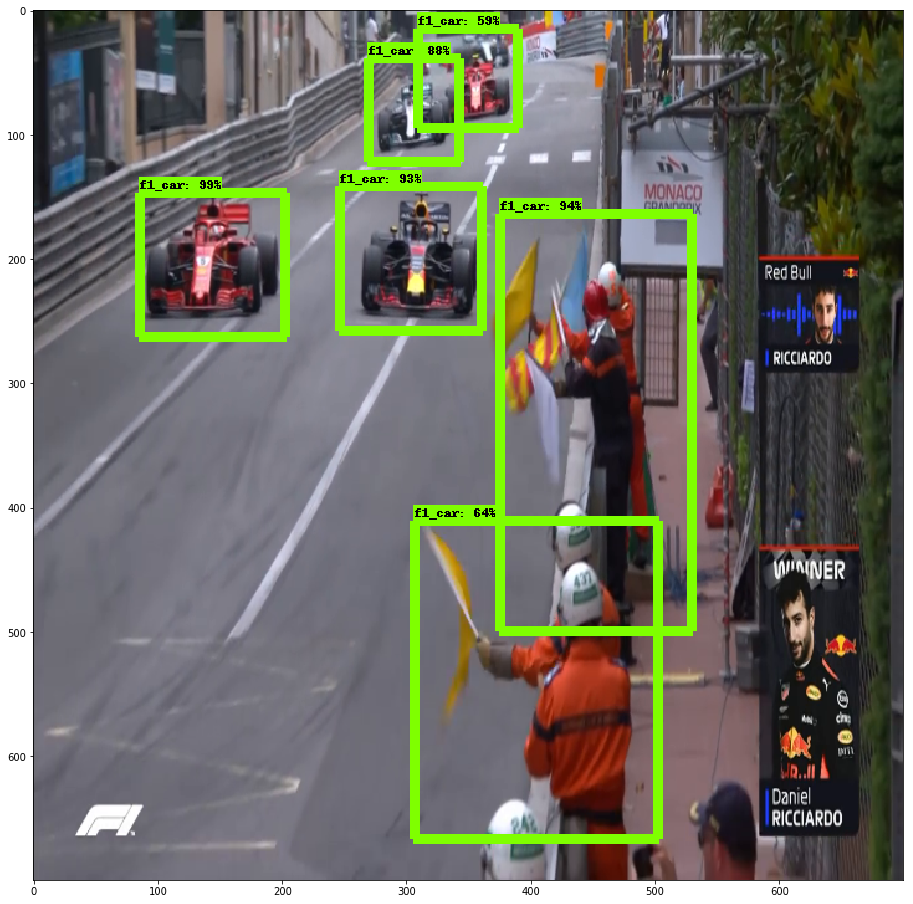

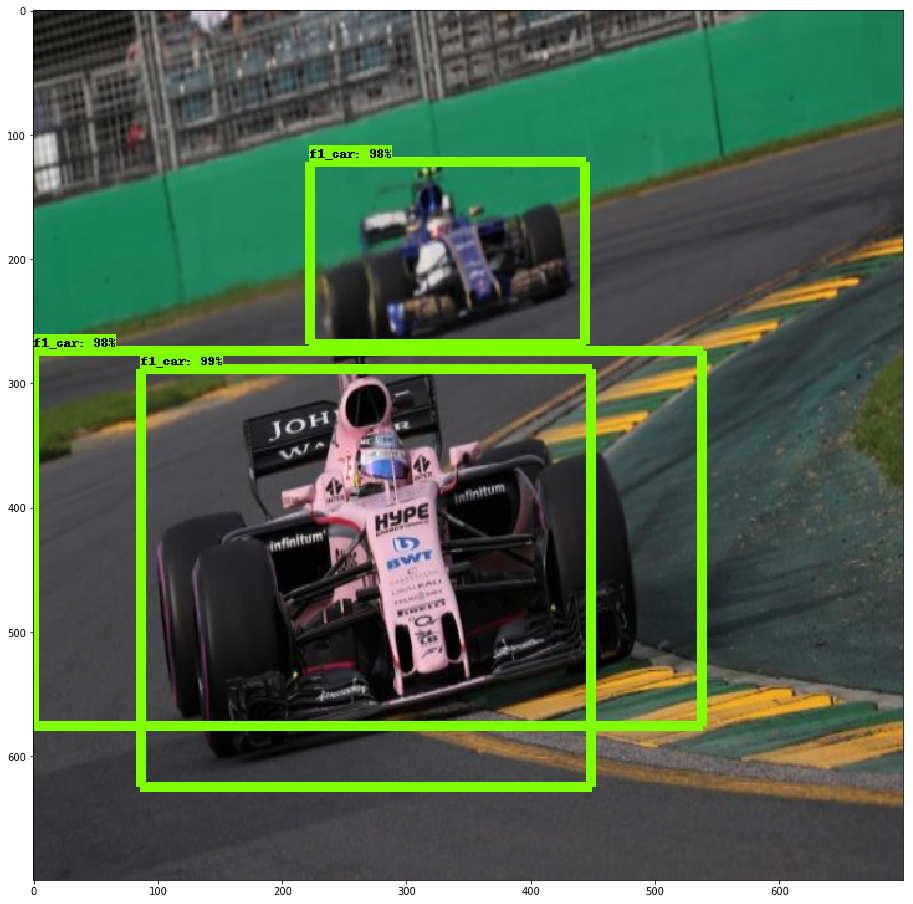

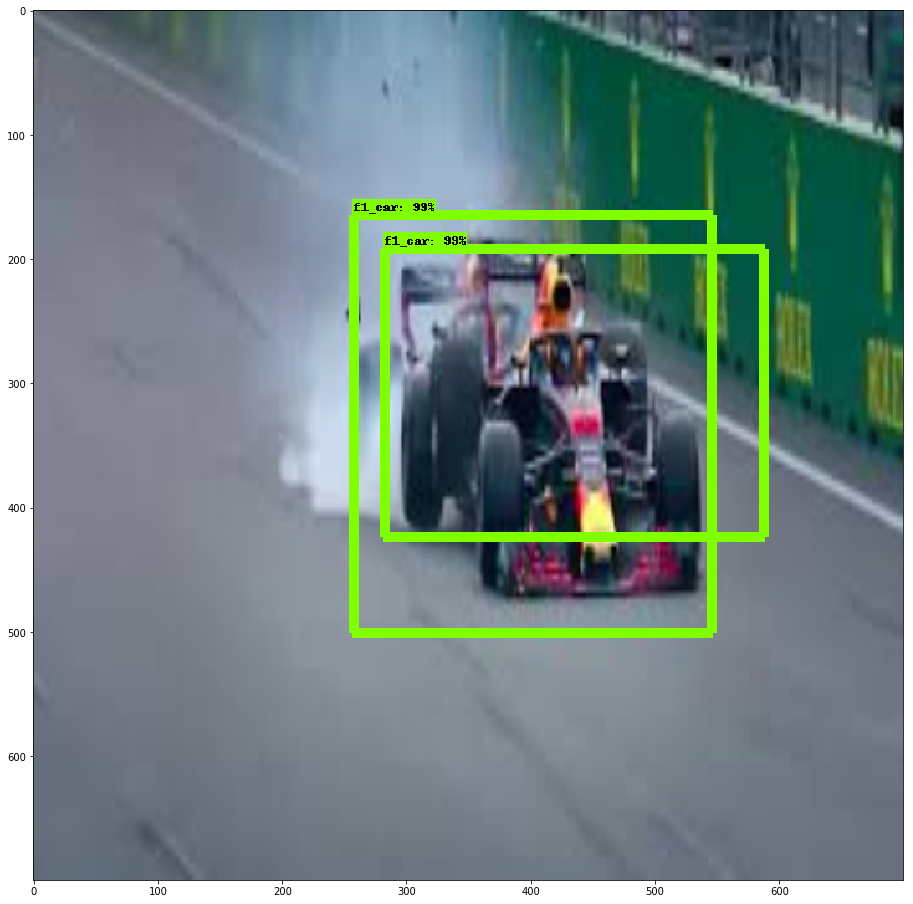

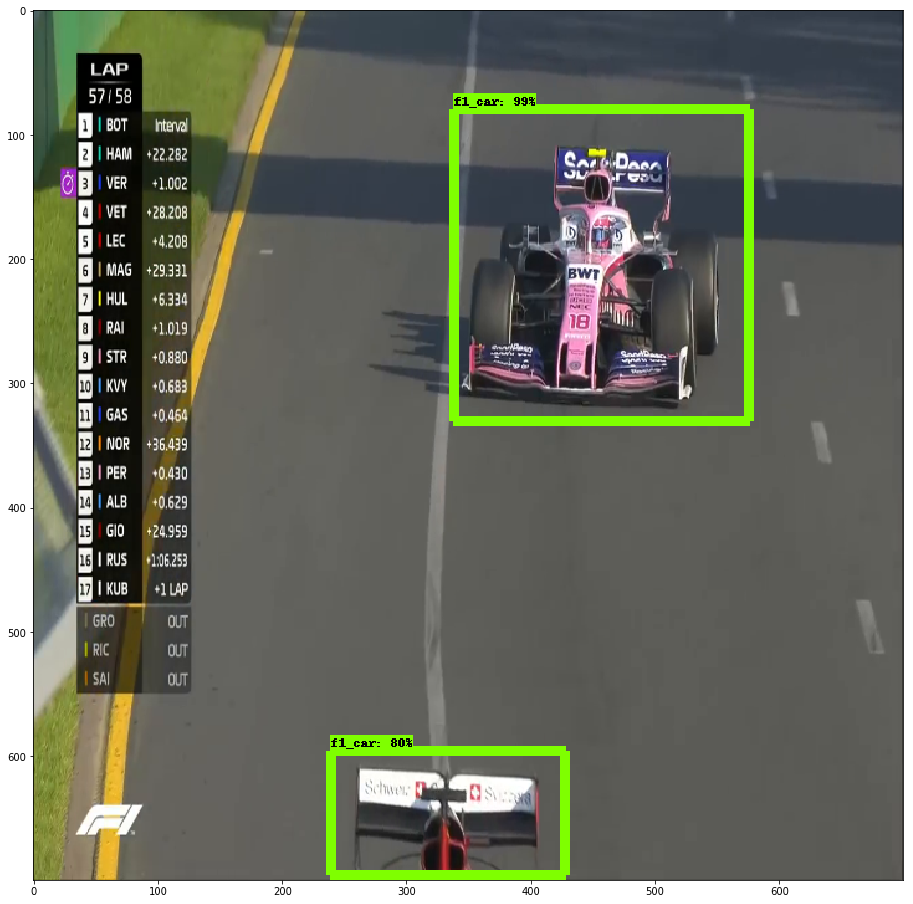

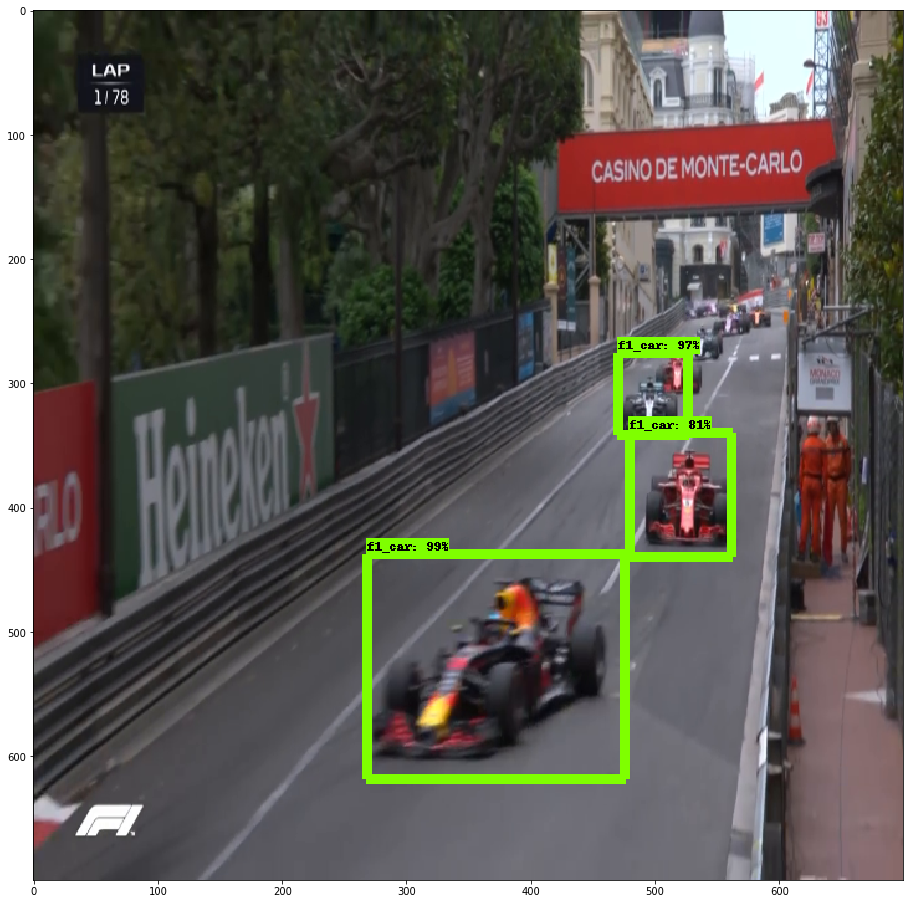

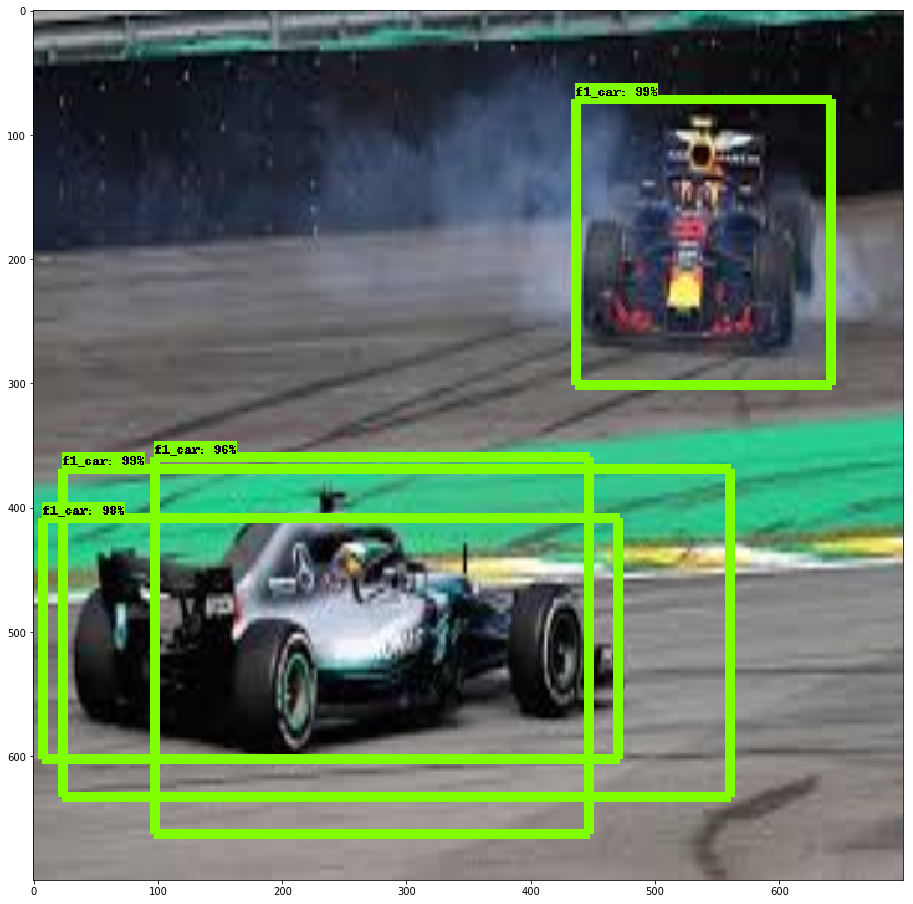

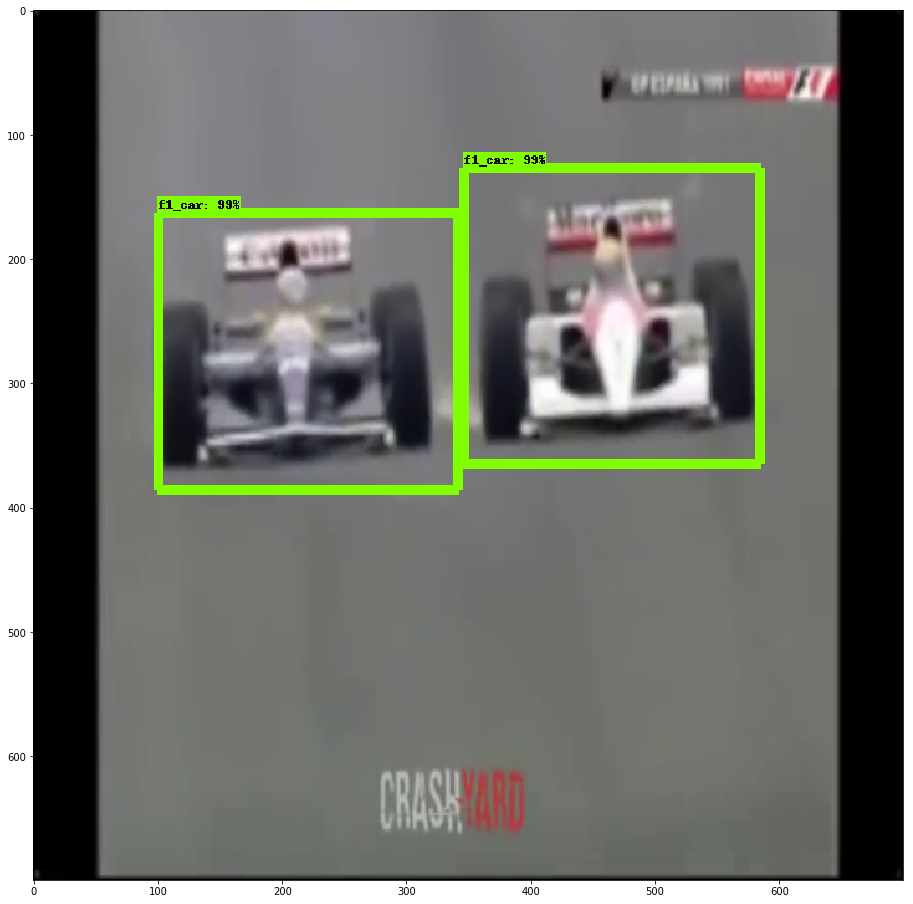

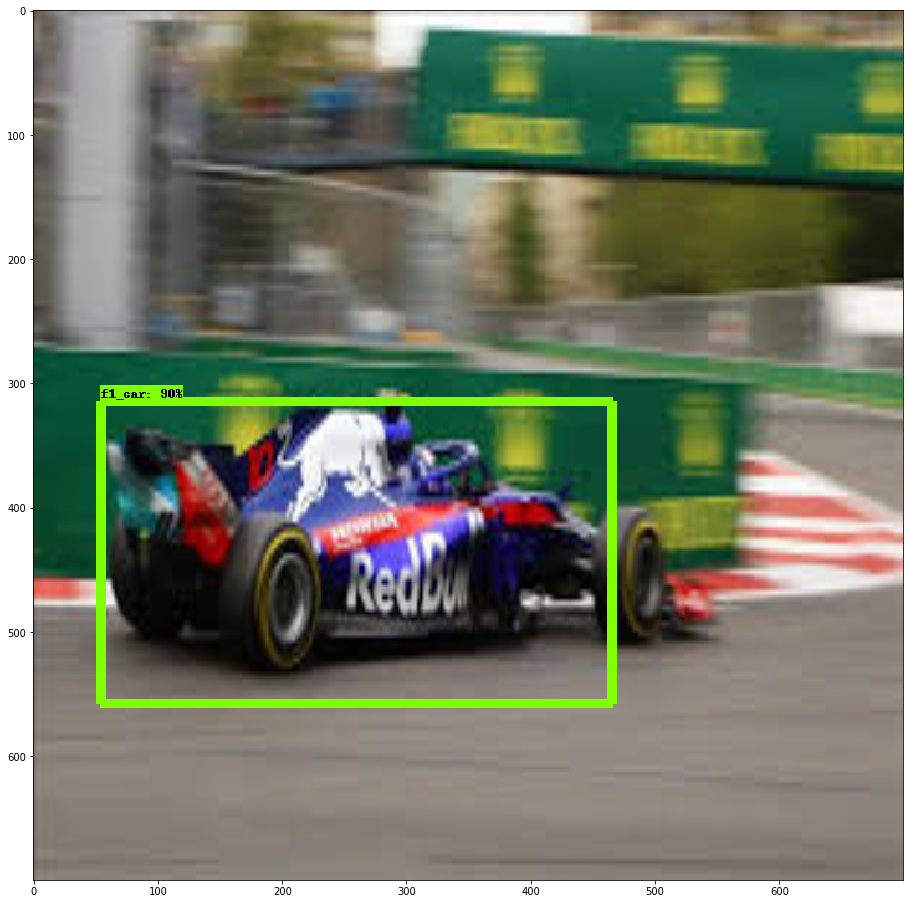

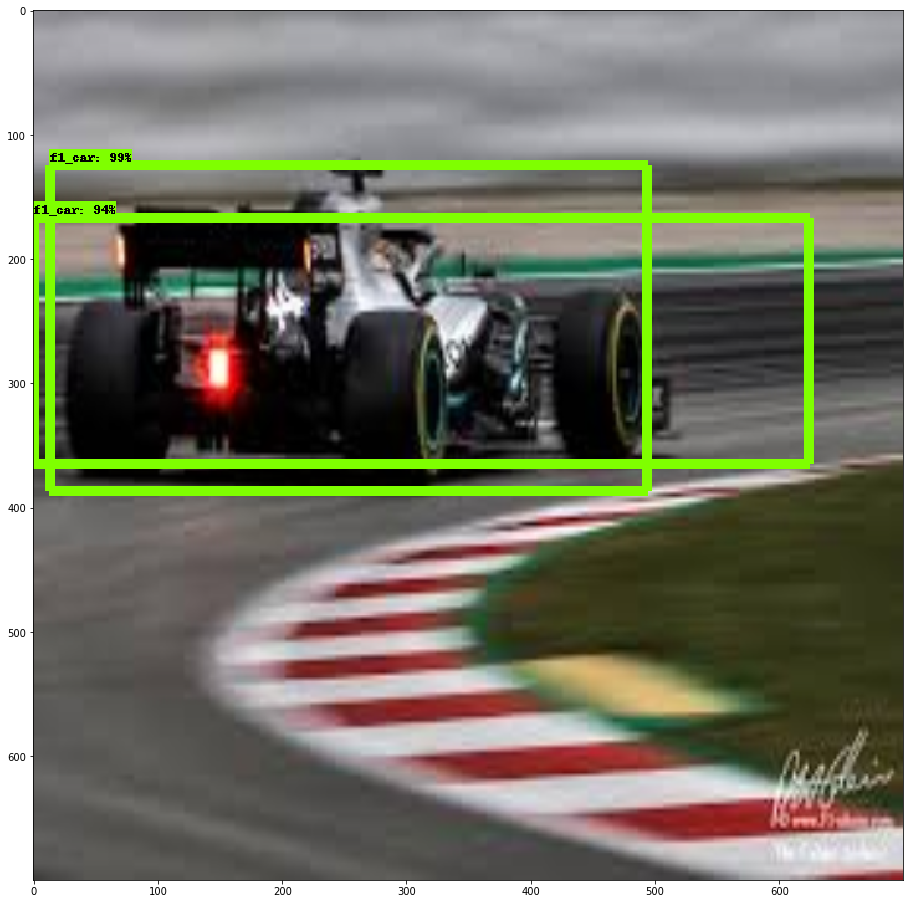

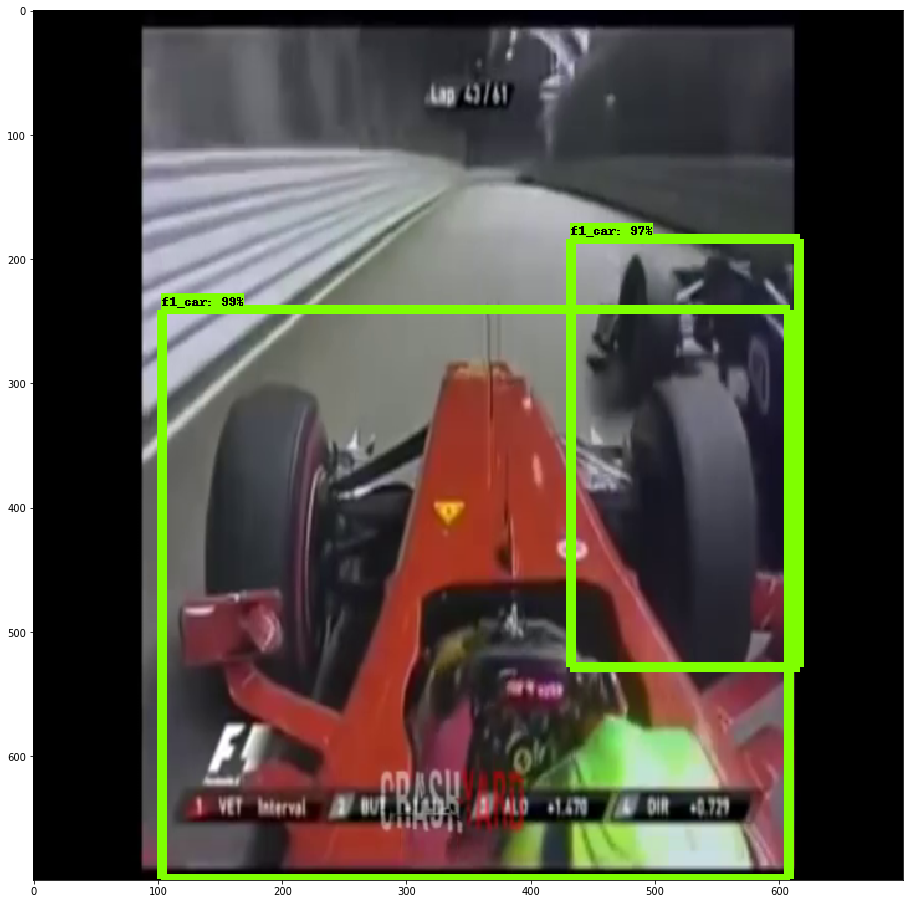

In [29]:
# Run Inference for Images

%matplotlib inline

for image_path in TEST_IMAGE_PATHS:
  
    image = Image.open(image_path)
    # Load images as numpy array
    image_np = load_image_into_numpy_array(image)
    
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=(16, 16))
    plt.imshow(image_np)